# Link Prediction

In this notebook, we will handle the task of link prediction on the Discogs collaboration network. We will use the processed data from the pipeline in final_data_processing.ipynb. 

More specifically, we will be using:
- discogs_edges.parquet: with source, target, and release year
- discogs_artists.parquet: with a list of all our Discogs artist, which will be our nodes

Using a time factor, we want to predict future collaborations. That is the idea of our link prediction. 

## Imports and Loading Data

In [1]:
# Note: Imports

import pandas as pd
import networkx as nx
import numpy as np

artists = pd.read_parquet('../data/final_data_processed/discogs_artists.parquet')
edges = pd.read_parquet('../data/final_data_processed/discogs_edges.parquet') # Note: These will be our nodes

edges.shape, artists.shape

((5673764, 3), (1045947, 1))

## Sorting Data and splitting

Here, each row in the edges df corresponds to a collaboration with source_id, target_id, release year.

What we will do is use release_year to perform a train/test split.

In [2]:
# Note: First we will sort the edges chronologically
edges_sorted = edges.sort_values(by='release_year')
edges_sorted[:100]


,source_id,target_id,release_year
684582,732692,149701,1897
5041494,1103193,847630,1897
1917426,327547,847635,1897
1936777,327547,847635,1897
3523093,1402460,3140943,1897
...,...,...,...
5389836,15578739,6141395,1903
5389837,15578739,15578742,1903
5595074,1804446,5158950,1903
5389838,6141395,15578742,1903


### Era-based Split

Here is something we noticed, the data starts from 1897, if we do just one single split on the data, then it does not make any sense of whatever prediction we will get, because music has seen such a change in eras, and also artists are not even the same in these eras. 

What we are going to do to tackle this is we have our edges sorted chronologically, so we will divide our entire Discogs dataset into different musical eras. This way, we preserve the genre ecosystems, the change in artists, the technology and recording environments, and actually get predictions that are better explainable.

It will also help us analyze and understand how collaboration changed over years, which will make our entire analysis even more insightful.

This it the division we will follow:
- Era 1: Early Recording (1897 - 1945)
- Era 2: Post-WWII / Early Rock (1946 - 1965)
- Era 3: Classic Rock / Studio Revolution (1966 - 1982)
- Era 4: MTV and Digital Sampling (1983 - 1999)
- Era 5: The Internet / Streaming Era (2000 - Present)

For each era, we will:
- Filter the edges inside the year range
- Recompute the artists set (all unqiue IDs appearing in that era)
- Store each era as its own DataFram for later train/test splitting

This way, we can run independent link prediction models inside each era.

In [3]:
# Note: Now, based on earlier divisions, let us create our 5 data splits

# Note: For each era, we will first extract the edges from edges_sorted for the relevant release years, following
# which we will build the era's artists df using the unique() source_id and target_ids of those edges

# Note: Era 1
era1_edges = edges_sorted[(edges_sorted['release_year'] >= 1897) & (edges_sorted['release_year'] <= 1945)]

era1_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era1_edges.source_id, era1_edges.target_id]))})
print('Era 1')
print(len(era1_edges), len(era1_artists))

# Note: Era 2
era2_edges = edges_sorted[(edges_sorted['release_year'] >= 1946) & (edges_sorted['release_year'] <= 1965)]

era2_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era2_edges.source_id, era2_edges.target_id]))})
print('Era 2')
print(len(era2_edges), len(era2_artists))

# Note: Era 3
era3_edges = edges_sorted[(edges_sorted['release_year'] >= 1966) & (edges_sorted['release_year'] <= 1982)]

era3_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era3_edges.source_id, era3_edges.target_id]))})
print('Era 3')
print(len(era3_edges), len(era3_artists))

# Note: Era 4
era4_edges = edges_sorted[(edges_sorted['release_year'] >= 1983) & (edges_sorted['release_year'] <= 2000)]

era4_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era4_edges.source_id, era4_edges.target_id]))})
print('Era 4')
print(len(era4_edges), len(era4_artists))

# Note: Era 5
era5_edges = edges_sorted[(edges_sorted['release_year'] >= 2000) & (edges_sorted['release_year'] <= 2025)]

era5_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era5_edges.source_id, era5_edges.target_id]))})
print('Era 5')
print(len(era5_edges), len(era5_artists))


Era 1
75692 20498
Era 2
649017 73293
Era 3
1153888 152055
Era 3
1153888 152055
Era 4
1542239 240600
Era 4
1542239 240600
Era 5
2338167 620672
Era 5
2338167 620672


## Train/Test Split for Each Era

In this bit, we will get the train/test splits for each musical era, and because we are doing a time based chronological split, we will follow a temporal link prediction methods (meaning we cannot use future collaborations to predict past ones), which will be as follows:

1. We will sort all the edges by the release_year
2. We will select a cutoff year for each era
3. All collaborations before or equal to the cut off year go into the train graph, and the latter into the test graph
4. Only the test edges where both nodes already exist in the train graph are kept

In [4]:
# Note: We will be using a function to get the cutoff year
def compute_cutoff(df, pct=0.8):
    years = df['release_year'].sort_values().unique()
    return years[int(len(years) * pct)]

# Note: Now just run it on the diff era edges we have
cut1 = compute_cutoff(era1_edges)
cut2 = compute_cutoff(era2_edges)
cut3 = compute_cutoff(era3_edges)
cut4 = compute_cutoff(era4_edges)
cut5 = compute_cutoff(era5_edges)

cut1, cut2, cut3, cut4, cut5

(np.int64(1936),
 np.int64(1962),
 np.int64(1979),
 np.int64(1997),
 np.int64(2020))

In [5]:
# Note: Now that we have our 3 cuts, we will implement that to get our train, test data for all 5 eras:

# Era 1 train/test split
era1_train = era1_edges[era1_edges['release_year'] <= cut1]
era1_test  = era1_edges[era1_edges['release_year'] > cut1]
print(f'Era 1: {len(era1_train), len(era1_test)}')

# Era 2 train/test split

era2_train = era2_edges[era2_edges['release_year'] <= cut2]
era2_test  = era2_edges[era2_edges['release_year'] > cut2]
print(f'Era 2: {len(era2_train), len(era2_test)}')

# Era 3 train/test split

era3_train = era3_edges[era3_edges['release_year'] <= cut3]
era3_test  = era3_edges[era3_edges['release_year'] > cut3]
print(f'Era 3: {len(era3_train), len(era3_test)}')

# Era 4 train/test split

era4_train = era4_edges[era4_edges['release_year'] <= cut4]
era4_test  = era4_edges[era4_edges['release_year'] > cut4]
print(f'Era 4: {len(era4_train), len(era4_test)}')

# Era 5 train/test split

era5_train = era5_edges[era5_edges['release_year'] <= cut5]
era5_test  = era5_edges[era5_edges['release_year'] > cut5]
print(f'Era 5: {len(era5_train), len(era5_test)}')

Era 1: (52269, 23423)
Era 2: (476093, 172924)
Era 3: (930641, 223247)
Era 4: (1285587, 256652)
Era 5: (1940401, 397766)
Era 4: (1285587, 256652)
Era 5: (1940401, 397766)


### Ensure Valid Test Edges

There is one thing though, a test edge (u,v) is only meaningful if both the nodes are in the train graph, otherwise the model will not be able to predict it using structural information, aka just looking at the graph data, of the train data. Therefore, we will filter the test sets to only include edges wehre: source_id is in train_nodes, target_id is in test_nodes.

A more explanable way to put this is, if we think about a cut off year, then the model only knows the artists up until that point, then if new artists come into play after that year then the model could not possible predict the artist's future collaborations because they never existed in the graph until after the test period began. Same idea for artists whose careers end.

In [6]:
# Note: We will use a function to help us filter as we discribed earlier
def filter_artist_only_after_test(train_edges, test_edges):
    train_nodes = set(train_edges['source_id']).union(train_edges['target_id'])
    return test_edges[(test_edges['source_id'].isin(train_nodes)) & (test_edges['target_id'].isin(train_nodes))] 

# Note: Now we just apply this filtering to each era
era1_test = filter_artist_only_after_test(era1_train, era1_test)
era2_test = filter_artist_only_after_test(era2_train, era2_test)
era3_test = filter_artist_only_after_test(era3_train, era3_test)
era4_test = filter_artist_only_after_test(era4_train, era4_test)
era5_test = filter_artist_only_after_test(era5_train, era5_test)

# Note: Now let us just print the final lengths after all processing before moving on to making the actual graphs
print("Era 1:", len(era1_train), len(era1_test))
print("Era 2:", len(era2_train), len(era2_test))
print("Era 3:", len(era3_train), len(era3_test))
print("Era 4:", len(era4_train), len(era4_test))
print("Era 5:", len(era5_train), len(era5_test))

Era 1: 52269 8905
Era 2: 476093 123529
Era 3: 930641 165516
Era 4: 1285587 158776
Era 5: 1940401 194184


## Build Train Graph

From here on out, until we do the final prediction on each train dataset for each era, what we will do is we will create functions such that we can then run these functions on each era to get the predictions.

For the first one, we are going to be building a train graph, given teh train edges for an era, we will construct an undirected nx Graph

In [7]:
def build_train_graph(train_df):
    # Note: We will be building the training graph given the training edges of an era
    G = nx.Graph()
    for _, row in train_df.iterrows():
        G.add_edge(row['source_id'], row['target_id'])
    return G

## Sampling Negative Edges

In this helper function, we will sample negative edges (u,v) such that: u != v, u and v both exist in the train graph and there is no edge u,v in the train graph

Basically, this aligns with the link prediction with the original Liben-Nowell % Kleinberg (2007) work, where the authors implicitly treat all non-edges as negative samples when ranking node similarity. Because our graph is very large, we follow the standard scalable apporximation used in modern graph mining and randomly sample an equal-szied set of non-edges to serve as negatives.

Reference: David Liben-Nowell and Jon Kleinberg. 2003. The link prediction problem for social networks. In Proceedings of the twelfth international conference on Information and knowledge management (CIKM '03). Association for Computing Machinery, New York, NY, USA, 556–559. https://doi.org/10.1145/956863.956972

In [8]:
import random

def sample_negative_edges(G, positive_edges, seed = 42):
    # Note: Here we will sample the engative edges equal in number to the positive edges
    random.seed(seed)
    nodes = list(G.nodes())
    negatives = set()
    target_count = len(positive_edges)

    while len(negatives) < target_count:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            negatives.add(tuple(sorted((u, v))))
    return list(negatives)

## Compute the Scores

Now here we will get the structural scores, as mentioned in the project abstract:
- Common Neighbors
- Jaccard Similarity
- Adamic-Adar Index
- Preferential Attachment (PA)

The ideas below and the idea for link prediction are inspired by the earlier mentioned paper by Liben-Nowell and Kleinberg.

In [9]:
def compute_scores(G, edge_list):
    # Note: Here we will compute the CN, Jaccard, Adamic-Adar, PA for the edges and return a df
    # Note: Common Neighbors
    cn_scores = [len(list(nx.common_neighbors(G, u, v))) for u, v in edge_list]

    # Note: Jaccard
    jaccard_dict = {(u, v): p for u, v, p in nx.jaccard_coefficient(G, edge_list)}
    jaccard_scores = [jaccard_dict.get((u, v), 0.0) for (u, v) in edge_list]

    # Note: Adamic-Adar
    # Note: We need to basically skip when deg=1 to avoid 1/log(1) division by zero, that is the only reason for
    # this implementation as is in the stack overflow link
    aa_scores = []
    for u, v in edge_list:
        aa_sum = 0.0
        for w in nx.common_neighbors(G, u, v):
            deg = G.degree(w)
            if deg > 1: aa_sum += 1 / np.log(deg)
        aa_scores.append(aa_sum)

    # Note: Preferential Attachment
    pa_dict = {(u, v): p for u, v, p in nx.preferential_attachment(G, edge_list)}
    pa_scores = [pa_dict.get((u, v), 0.0) for (u, v) in edge_list]

    # Note: Return a DF w/ all the computed scores
    return pd.DataFrame({'u' : [u for u, v in edge_list],'v': [v for u, v in edge_list],'cn': cn_scores,'jaccard': jaccard_scores, 'aa': aa_scores, 'pa': pa_scores})
# Reference: https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html
# Reference: https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html
# Reference: https://stackoverflow.com/questions/29836964/error-python-zerodivisionerror-division-by-zero
# Reference: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html
# Reference: David Liben-Nowell and Jon Kleinberg. 2003. The link prediction problem for social networks. In Proceedings of the twelfth international conference on Information and knowledge management (CIKM '03). Association for Computing Machinery, New York, NY, USA, 556–559. https://doi.org/10.1145/956863.956972


## Full Pipeline for each era

Now, through this function, we will run the entire link prediction pipeline for on era

Here's what this function does:
1. Build a training graph
2. Construct positive edges (test set)
3. Sample negative edges
4. Compute the scores for both
5. Put results into the data frame

In [10]:
def run_pipeline_for_era(train_df, test_df):
    # Note: Run full link prediction pipeline (training + structural scoring); this returns a DataFrame with predictions
    
    # Note: First build train graph
    G = build_train_graph(train_df)

    # Note: Then we get the positive edges
    positives = list(zip(test_df['source_id'], test_df['target_id']))

    # Note: Then we get the negative edges
    negatives = sample_negative_edges(G, positives)

    # Note: Then we get the scores for all edges
    all_edges = positives + negatives
    labels = [1]*len(positives) + [0]*len(negatives)

    scores_df = compute_scores(G, all_edges)
    scores_df['label'] = labels

    return scores_df

## Run the actual pipeline on the eras
Now that we have our pipleine ready, we will run it on all 5 eras, each result will be saved separately

Here's what we will get and how we will use that for the pipeline, just briefly explaining the entire process and what the results actually mean and how the evaluation phase will look like(since link prediction here is diff from ML based link prediction).

### What the pipeline above is doing
1. Firstly we are building the training graph for an era, here we use only the collaborations that occured up to the era's cutoff year. This gives us a graph G_train that will have the nodes which will be the artists known by that time, and the edges which will be the collaborations before the cutoff year.
2. It then helps us identify the future collaborations (positives), basically these are the artists that in the next time window (the test period), actually collaborated in reality. These are what we try to predict
3. We then sample the negative (non-edge) examples, where we randomly select the sample pairs of artists (u, v) that existed in the train graph, but did not collaborate in the train graph and are not connected in the test set either. These serve as the non-collaborations. This follows the standard method in Liben-Nowell & Kleinberg (2007). We match the number of positive examples so the dataset is balanced.
4. We then compute the 4 link-prediction scores, where for every positive and negative pair we have: Common Neighbors, Jaccard Coefficient, Adamic-Adar, Preferential Attachment. These scores tell us how strongly the graph structure suggests a link between the two artists. This step is the actual prediction part, meaning there is no training or machine learning model here but structural link prediction uses graph topology directly.
5. We then combine the scores and labels into one data frame, where for each pair, we get all the stuff in the dataframe as we can see above. This dataframe is the final output of the pipeline. We save it separately for Eras 1-5.

### What the evaluation phase will look like now
1. First step will be loading the score datafram for each era wehre each row represents a predicted vs non-predicted collaboration
2. It also computes the evaluation metrics, such as AUC, Precision, Recall, Hits, Average Precision, these metrics will tell us how well the structural scores separate real future edges from non-edges
3. Compare methods by determining which structural mechanism is strongest, like is it the triadic closure or homophily/Jaccard or PA?
4. We will visualize the findings like all the curves and score distributions and Gephi with diff features

Here's a simpler way to put everything, calculate the scores for 2 artists who don't collaborate in the train, and then look at their actual score in the test set, then compare that with the fact of whether they actually collaborate in the future or not, then compare which indicator or score actually makes more sense on future collaborations.

**Now let us actually run our above pipeline and get all the results**


In [11]:
all_results = {}

# Note: A dict will help go through each era
eras = {
    "Era1": (era1_train, era1_test),
    "Era2": (era2_train, era2_test),
    "Era3": (era3_train, era3_test),
    "Era4": (era4_train, era4_test),
    "Era5": (era5_train, era5_test)
}
for era, (train_df, test_df) in eras.items():
    print(f'Running {era}')
    result_df = run_pipeline_for_era(train_df, test_df)
    all_results[era] = result_df

Running Era1
Running Era2
Running Era2
Running Era3
Running Era3
Running Era4
Running Era4
Running Era5
Running Era5


## Imports for Collaboration-driven communities

In [12]:
import community.community_louvain as community_louvain
import time
from collections import Counter
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Community-Based Link Prediction

This notebook will explore **Collaboration-driven communities** - detected using Louvain Community Detection



## Louvain Community Detection (Faster)

The fastest and most widely-used algorithm for large networks.

Citations used for code below:
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html

In [13]:
def detect_communities_louvain(G):
    # so i know how long the algo runs for each era
    start_time = time.time() 
    print(f"Louvain running on graph with {G.number_of_nodes()} nodes, and {G.number_of_edges()} edges")
    
    # apply louvain community detection
    partition = community_louvain.best_partition(G, resolution=1.0, random_state=42)
    
    total_time = time.time() - start_time
    num_communities = len(set(partition.values()))
    print(f"Detected {num_communities} communities. Took {total_time:.3f}s")
    
    # modulatiry check
    modularity = community_louvain.modularity(partition, G)
    print(f"Modularity: {modularity:.5f}")

    return partition

# store  communities 
era_communities = {}

# run louvain for each era on the train data set.
for era_num, (era, (train_df, test_df)) in enumerate(eras.items(), 1):
    print(f"[{era_num}/5] {era}")
    print(f"\n==========")
    G_train = build_train_graph(train_df)
    
    communities = detect_communities_louvain(G_train)
    era_communities[era] = communities

[1/5] Era1

Louvain running on graph with 15133 nodes, and 25611 edges
Louvain running on graph with 15133 nodes, and 25611 edges
Detected 2667 communities. Took 1.022s
Modularity: 0.86870
[2/5] Era2

Detected 2667 communities. Took 1.022s
Modularity: 0.86870
[2/5] Era2

Louvain running on graph with 56358 nodes, and 148663 edges
Louvain running on graph with 56358 nodes, and 148663 edges
Detected 8983 communities. Took 8.729s
Modularity: 0.77171
[3/5] Era3

Detected 8983 communities. Took 8.729s
Modularity: 0.77171
[3/5] Era3

Louvain running on graph with 126186 nodes, and 313128 edges
Louvain running on graph with 126186 nodes, and 313128 edges
Detected 25911 communities. Took 17.521s
Detected 25911 communities. Took 17.521s
Modularity: 0.77229
[4/5] Era4

Modularity: 0.77229
[4/5] Era4

Louvain running on graph with 191545 nodes, and 509935 edges
Louvain running on graph with 191545 nodes, and 509935 edges
Detected 41075 communities. Took 29.195s
Detected 41075 communities. Took 29

## Community-Based Features

Now we are going to work on computing the community based features. The way we will do this is that for each edge pair we will compute wheter or not they are the same community (done using binary indicator). Jaccard similarity of their community neighbors (check for similarity). And then how connected they are within their own community (degree).

Below is a helper function for the pipeline.

In [14]:
def compute_community_features(G, edge_list, communities):
    community_sizes = Counter(communities.values())
    
    features = []
    
    for u, v in edge_list:
        # get function to ignore errors being thrown otherwise
        comm_u = communities.get(u, -1)
        comm_v = communities.get(v, -1)
        
        # check if same community
        if comm_u == comm_v and comm_u != -1:
            same_comm = 1
        else:
            same_comm = 0
        
        # jaccard computation
        common_neighs = list(nx.common_neighbors(G, u, v))
        if same_comm:
            within_comm_cn = sum(1 for n in common_neighs if communities.get(n, -1) == comm_u)
        else:
            within_comm_cn = 0
        
        
        comm_size_u = community_sizes.get(comm_u, 0)
        comm_size_v = community_sizes.get(comm_v, 0)
        
        features.append({
            'same_community': same_comm,
            'within_community_cn': within_comm_cn,
            'community_size_u': comm_size_u,
            'community_size_v': comm_size_v
        })
    
    return pd.DataFrame(features)

## Running the Community-Based Pipeline for Each Era

In [15]:
def run_community_pipeline_for_era(train_df, test_df, communities):
    G = build_train_graph(train_df)
    
    # positive edges and sample negative edges
    positives = list(zip(test_df['source_id'], test_df['target_id']))
    negatives = sample_negative_edges(G, positives)
    
    # label the positive edges as 1 and the negative ones as 0
    all_edges = positives + negatives
    labels = [1] * len(positives) + [0] * len(negatives)
    
    # compute the community features by calling our previous function
    community_features = compute_community_features(G, all_edges, communities)
    community_features['label'] = labels
    community_features['u'] = [u for u, v in all_edges]
    community_features['v'] = [v for u, v in all_edges]
    
    return community_features

# dict will hold all the eras. mapping will be from era to results
community_results = {}

for era, (train_df, test_df) in eras.items():
    print(f"Community pipeline for {era}")
    comms = era_communities[era]
    result_df = run_community_pipeline_for_era(train_df, test_df, comms)
    community_results[era] = result_df
    print(f"{era}: {len(result_df)} samples ({result_df['label'].sum()} are positive)")

Community pipeline for Era1
Era1: 17810 samples (8905 are positive)
Community pipeline for Era2
Era1: 17810 samples (8905 are positive)
Community pipeline for Era2
Era2: 247058 samples (123529 are positive)
Community pipeline for Era3
Era2: 247058 samples (123529 are positive)
Community pipeline for Era3
Era3: 331032 samples (165516 are positive)
Community pipeline for Era4
Era3: 331032 samples (165516 are positive)
Community pipeline for Era4
Era4: 317552 samples (158776 are positive)
Community pipeline for Era5
Era4: 317552 samples (158776 are positive)
Community pipeline for Era5
Era5: 388368 samples (194184 are positive)
Era5: 388368 samples (194184 are positive)


## Homophily Analysis: Do Same-Community Artists Collaborate More?

This will determine whether or not artists in the same community collaborate more or not.

In [16]:
for era, df in community_results.items():
    print(f"\n for: {era}:")
    print(f"\n==========")

    # split into positive and negative links based on labels
    positive_links = df[df['label'] == 1]
    negative_links = df[df['label'] == 0]
    
    # what is the rate of same community, compute for both positve and negative links
    same_comm_positive = positive_links['same_community'].mean() * 100
    same_comm_negative = negative_links['same_community'].mean() * 100
    
    print(f"Positive links (representation of actual collaborations):")
    print(f"Same community: {same_comm_positive:.1f}%")
    print(f"Negative links (representation of non collaborations):")
    print(f"Same community: {same_comm_negative:.1f}%")
    print(f"Difference between positive and negative comms: {same_comm_positive - same_comm_negative:.1f}")
    
    # does being in the same community predict links? (using auc)
    if df['same_community'].nunique() > 1:
        auc = roc_auc_score(df['label'], df['same_community'])
        print(f"AUC using 'same_community': {auc:.4f}")
    
    # in community Jaccard common neighbors analysis
    avg_within_cn_pos = positive_links['within_community_cn'].mean()
    avg_within_cn_neg = negative_links['within_community_cn'].mean()
    print(f"Avg in community common neighbors:")
    print(f"Pos links: {avg_within_cn_pos:.3f}")
    print(f"Neg links: {avg_within_cn_neg:.3f}")



 for: Era1:

Positive links (representation of actual collaborations):
Same community: 85.8%
Negative links (representation of non collaborations):
Same community: 2.7%
Difference between positive and negative comms: 83.1
AUC using 'same_community': 0.9157
Avg in community common neighbors:
Pos links: 4.357
Neg links: 0.001

 for: Era2:

Positive links (representation of actual collaborations):
Same community: 79.5%
Negative links (representation of non collaborations):
Same community: 2.6%
Difference between positive and negative comms: 76.9
AUC using 'same_community': 0.8846
Avg in community common neighbors:
Pos links: 21.724
Neg links: 0.003

 for: Era3:

Positive links (representation of actual collaborations):
Same community: 73.4%
Negative links (representation of non collaborations):
Same community: 1.5%
Difference between positive and negative comms: 71.9
AUC using 'same_community': 0.8593
Avg in community common neighbors:
Pos links: 21.862
Neg links: 0.002

 for: Era4:

Pos

## Visualization of Homophily Across the 5 Eras

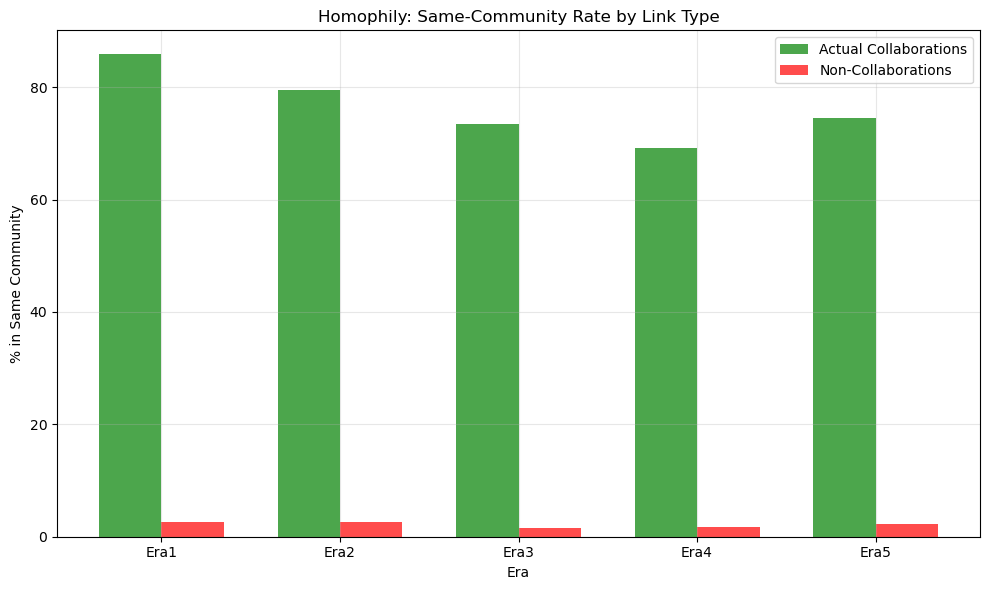

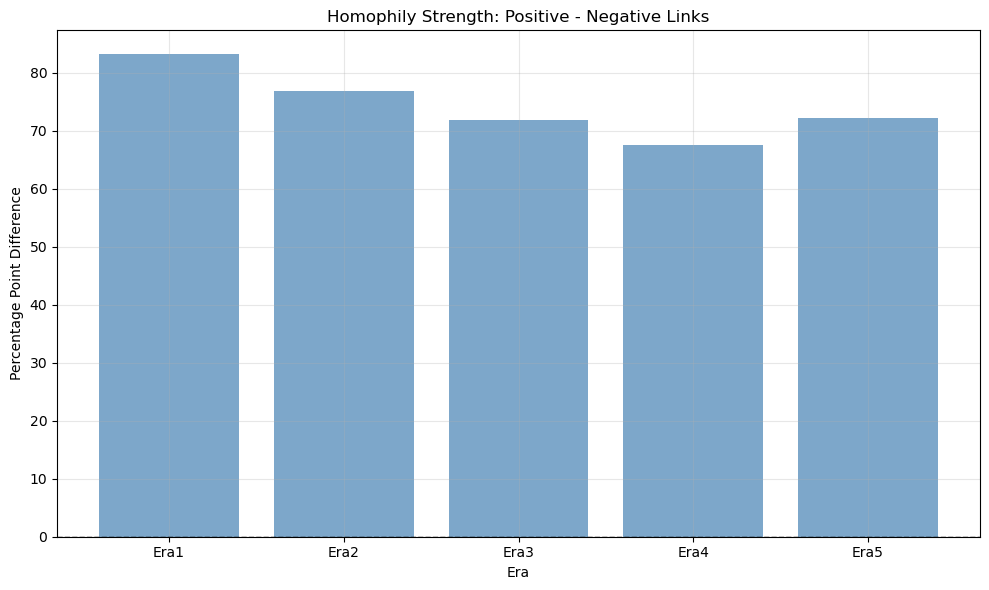


Homophily Summary:
 Era  Positive  Negative  Difference
Era1 85.816957  2.683885   83.133071
Era2 79.531932  2.613961   76.917971
Era3 73.367529  1.515261   71.852268
Era4 69.210082  1.647604   67.562478
Era5 74.454126  2.299366   72.154760


In [17]:
homophily_data = []
for era, df in community_results.items():
    positive = df[df['label'] == 1]
    negative = df[df['label'] == 0]
    
    homophily_data.append({
        'Era': era,
        'Positive': positive['same_community'].mean() * 100,
        'Negative': negative['same_community'].mean() * 100
    })

homophily_df = pd.DataFrame(homophily_data)

# plt 1: same-community rates for positive vs negative links
plt.figure(figsize=(10, 6))
x = np.arange(len(homophily_df))
width = 0.35

bars1 = plt.bar(x - width/2, homophily_df['Positive'], width, label='Actual Collaborations', color='green', alpha=0.7)
bars2 = plt.bar(x + width/2, homophily_df['Negative'], width, label='Non-Collaborations', color='red', alpha=0.7)

plt.xlabel('Era')
plt.ylabel('% in Same Community')
plt.title('Homophily: Same-Community Rate by Link Type')
plt.xticks(x, homophily_df['Era'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# plt 2: homophily difference (positive - negative)
plt.figure(figsize=(10, 6))
homophily_df['Difference'] = homophily_df['Positive'] - homophily_df['Negative']
bars = plt.bar(homophily_df['Era'], homophily_df['Difference'], color='steelblue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Era')
plt.ylabel('Percentage Point Difference')
plt.title('Homophily Strength: Positive - Negative Links')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHomophily Summary:")
print(homophily_df.to_string(index=False))

## Comparison Between Community Features and Structural Features

Do community-based features improve upon the addition of basic structure features?

In [18]:
# reuse results from earlier
structural_results = all_results
# comparison between community features and structural features
comparison_data = []

for era in eras.keys():
    struct_df = structural_results[era]
    comm_df = community_results[era]
    
    print(f"\nThis is {era}:")
    # calculate AUC for each of the structural features, only if unique
    struct_aucs = {}
    for feature in ['cn', 'jaccard', 'aa', 'pa']:
        if struct_df[feature].nunique() > 1:
            auc = roc_auc_score(struct_df['label'], struct_df[feature])
            struct_aucs[feature] = auc
            print(f"{feature} AUC: {auc:.3f}")
    
    # calculate AUC for same community features
    if comm_df['same_community'].nunique() > 1:
        comm_auc = roc_auc_score(comm_df['label'], comm_df['same_community'])
        print(f"Same Community AUC: {comm_auc:.3f}")
    
    # calculate CN AUC for in-community
    if comm_df['within_community_cn'].nunique() > 1:
        within_cn_auc = roc_auc_score(comm_df['label'], comm_df['within_community_cn'])
        print(f"  Within-Community CN AUC: {within_cn_auc:.3f}")
    
    comparison_data.append({
        'Era': era,
        'CN': struct_aucs.get('cn', 0),
        'Jaccard': struct_aucs.get('jaccard', 0),
        'Adamic-Adar': struct_aucs.get('aa', 0),
        'PA': struct_aucs.get('pa', 0),
        'Same Community': comm_auc if comm_df['same_community'].nunique() > 1 else 0,
        'Within-Community CN': within_cn_auc if comm_df['within_community_cn'].nunique() > 1 else 0
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nSummary:")
print(comparison_df.to_string(index=False))


This is Era1:
cn AUC: 0.863
jaccard AUC: 0.863
aa AUC: 0.862
pa AUC: 0.927
Same Community AUC: 0.916
  Within-Community CN AUC: 0.843

This is Era2:
cn AUC: 0.925
jaccard AUC: 0.924
aa AUC: 0.924
pa AUC: 0.957
Same Community AUC: 0.885
  Within-Community CN AUC: 0.857

This is Era3:
cn AUC: 0.926
jaccard AUC: 0.925
aa AUC: 0.925
pa AUC: 0.961
Same Community AUC: 0.859
  Within-Community CN AUC: 0.824

This is Era4:
cn AUC: 0.926
jaccard AUC: 0.925
aa AUC: 0.925
pa AUC: 0.961
Same Community AUC: 0.859
  Within-Community CN AUC: 0.824

This is Era4:
cn AUC: 0.887
jaccard AUC: 0.887
aa AUC: 0.887
pa AUC: 0.936
Same Community AUC: 0.838
  Within-Community CN AUC: 0.786

This is Era5:
cn AUC: 0.887
jaccard AUC: 0.887
aa AUC: 0.887
pa AUC: 0.936
Same Community AUC: 0.838
  Within-Community CN AUC: 0.786

This is Era5:
cn AUC: 0.753
jaccard AUC: 0.753
aa AUC: 0.753
pa AUC: 0.887
Same Community AUC: 0.861
  Within-Community CN AUC: 0.727

Summary:
 Era       CN  Jaccard  Adamic-Adar       PA 

## Visualize AUC Comparison

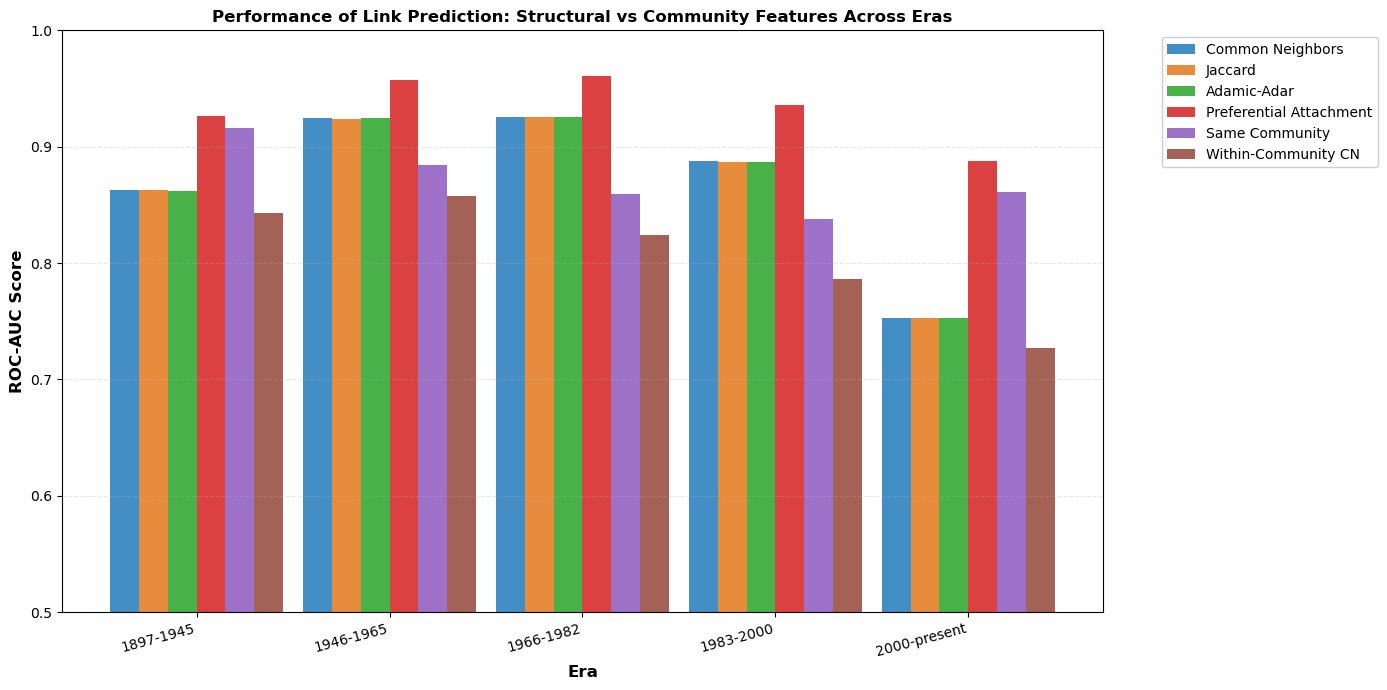


1897-1945:
Best Metric: Preferential Attachment (AUC = 0.9266)
Community features avg=0.8793 outperforms structural avg=0.8785

1946-1965:
Best Metric: Preferential Attachment (AUC = 0.9570)
Structural features avg=0.9325 outperforms community avg=0.8710

1966-1982:
Best Metric: Preferential Attachment (AUC = 0.9609)
Structural features avg=0.9343 outperforms community avg=0.8417

1983-2000:
Best Metric: Preferential Attachment (AUC = 0.9362)
Structural features avg=0.8993 outperforms community avg=0.8119

2000-present:
Best Metric: Preferential Attachment (AUC = 0.8874)
Community features avg=0.7937 outperforms structural avg=0.7864


In [19]:
# mapping of the names
era_name_map = {
    'Era1': '1897-1945',
    'Era2': '1946-1965',
    'Era3': '1966-1982',
    'Era4': '1983-2000',
    'Era5': '2000-present'
}
comparison_df['Era_Name'] = comparison_df['Era'].map(era_name_map)

metrics_to_plot = ['CN', 'Jaccard', 'Adamic-Adar', 'PA', 'Same Community', 'Within-Community CN']
metric_labels = ['Common Neighbors', 'Jaccard', 'Adamic-Adar', 'Preferential Attachment', 
                 'Same Community', 'Within-Community CN']

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(comparison_df))
width = 0.15 
colors = ["#1473b7", "#e2700c", "#1a9f1a", "#d21111", "#854db9", "#8c3b2b"]

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    values = comparison_df[metric].values
    offset = (i - len(metrics_to_plot)/2 + 0.5) * width
    ax.bar(x + offset, values, width, label=label, color=colors[i], alpha=0.8)

ax.set_xlabel('Era', fontsize=12, fontweight='bold')
ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Performance of Link Prediction: Structural vs Community Features Across Eras', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Era_Name'], rotation=15, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()


for _, row in comparison_df.iterrows():
    era_name = row['Era_Name']
    metric_scores = {label: row[metric] for metric, label in zip(metrics_to_plot, metric_labels)}
    best_metric = max(metric_scores, key=metric_scores.get)
    best_score = metric_scores[best_metric]
    print(f"\n{era_name}:")
    print(f"Best Metric: {best_metric} (AUC = {best_score:.4f})")
    
    comm_avg = (row['Same Community'] + row['Within-Community CN']) / 2
    struct_avg = (row['CN'] + row['Jaccard'] + row['Adamic-Adar'] + row['PA']) / 4
    
    if comm_avg > struct_avg:
        print(f"Community features avg={comm_avg:.4f} outperforms structural avg={struct_avg:.4f}")
    else:
        print(f"Structural features avg={struct_avg:.4f} outperforms community avg={comm_avg:.4f}")


# Detailed Metric Evaluation

Now let's compute comprehensive evaluation metrics for all structural and community features across all eras, including:
- **AUC**: Area Under the ROC Curve
- **Precision**: Proportion of predicted positives that are actually positive
- **Recall**: Proportion of actual positives that are correctly predicted
- **Hits@K**: Fraction of true edges in top K predictions
- **Score Distributions**: Visualize the distribution of scores

In [20]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

def normalizeCol(df, col):
    min_val = df[col].min()
    max_val = df[col].max()
    if max_val > min_val:
        df[col] = (df[col] - min_val) / (max_val - min_val)
    return df

def evaluate(df, graphMetric, threshold=0.5):
    # ----- AUC -----
    if df[graphMetric].nunique() > 1:
        auc = roc_auc_score(df['label'], df[graphMetric])
        print(f"AUC: {auc}")
    else:
        print(f"AUC: N/A (constant predictions)")
        auc = 0.5
    
    # ----- Precision -----
    y_pred = [1 if s >= threshold else 0 for s in df[graphMetric]]
    if sum(y_pred) > 0: 
        precision = precision_score(df['label'], y_pred, zero_division=0)
        print(f"Precision: {precision}")
    else:
        print(f"Precision: N/A (no positive predictions)")
        precision = 0.0
    
    # ----- Recall -----
    recall = recall_score(df['label'], y_pred, zero_division=0)
    print(f"Recall: {recall}")
    
    # ----- Hits@K -----
    K = 1000
    edges = list(zip(df['u'], df['v']))
    predicted_edges = pd.DataFrame({
        'edge': edges,
        'score': df[graphMetric]
    })
    
    # Sort by score descending
    predicted_edges_sorted = predicted_edges.sort_values('score', ascending=False)
    
    # Take top K edges
    K_actual = min(K, len(predicted_edges_sorted))
    top_k_edges = set(predicted_edges_sorted['edge'].iloc[:K_actual])
    
    # Get actual positive edges
    positive_edges = set(zip(df[df['label'] == 1]['u'], df[df['label'] == 1]['v']))
    
    # Count how many true edges are in top K
    hits = len(top_k_edges.intersection(positive_edges))
    
    # Compute Hits@K
    hits_at_k = hits / K_actual if K_actual > 0 else 0
    print(f"  Hits@{K_actual}: {hits_at_k:.4f} ({hits}/{K_actual} top predictions are true edges)")
    
    # ----- Score Distribution -----
    plt.figure(figsize=(8, 4))
    
    # separate positive and negative samples
    positive_scores = df[df['label'] == 1][graphMetric]
    negative_scores = df[df['label'] == 0][graphMetric]
    
    plt.hist(positive_scores, bins=50, alpha=0.6, label='Positive (True Collaborations)', color='green')
    plt.hist(negative_scores, bins=50, alpha=0.6, label='Negative (Non-Collaborations)', color='red')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold={threshold}')
    
    plt.title(f"Score Distribution: {graphMetric}")
    plt.xlabel("Normalized Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'metric': graphMetric,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'hits_at_k': hits_at_k
    }

## Evaluate Structural Features

evaluating Era1 - structural features

--- Metric: cn ---
AUC: 0.8627797945813332
Precision: 1.0
Recall: 0.00022459292532285232
  Hits@1000: 0.1920 (192/1000 top predictions are true edges)


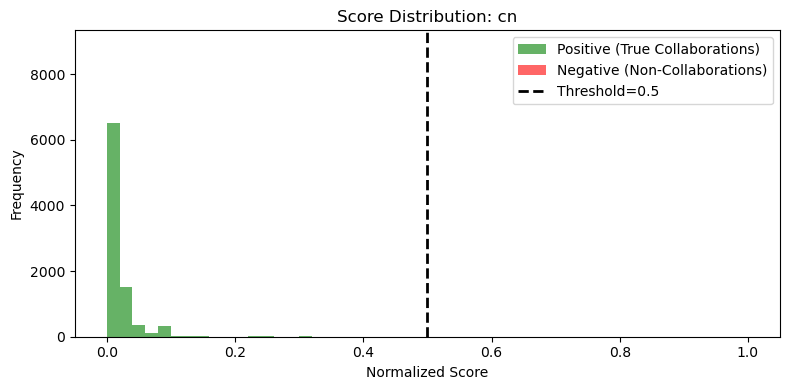


--- Metric: jaccard ---
AUC: 0.8625030509517614
Precision: 1.0
Recall: 0.08287478944413251
  Hits@1000: 0.2410 (241/1000 top predictions are true edges)


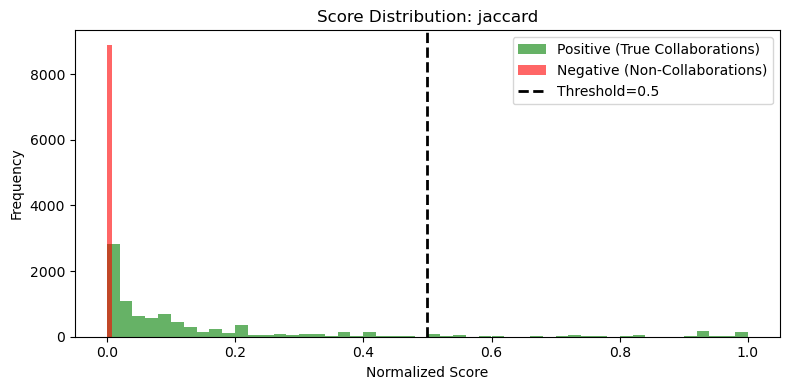


--- Metric: aa ---
AUC: 0.861943996158843
Precision: 1.0
Recall: 0.00022459292532285232
  Hits@1000: 0.1970 (197/1000 top predictions are true edges)


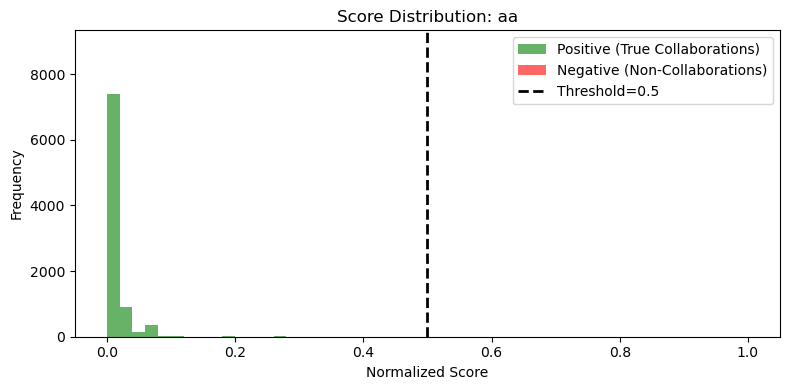


--- Metric: pa ---
AUC: 0.926583384852462
Precision: 1.0
Recall: 0.00022459292532285232
  Hits@1000: 0.2580 (258/1000 top predictions are true edges)


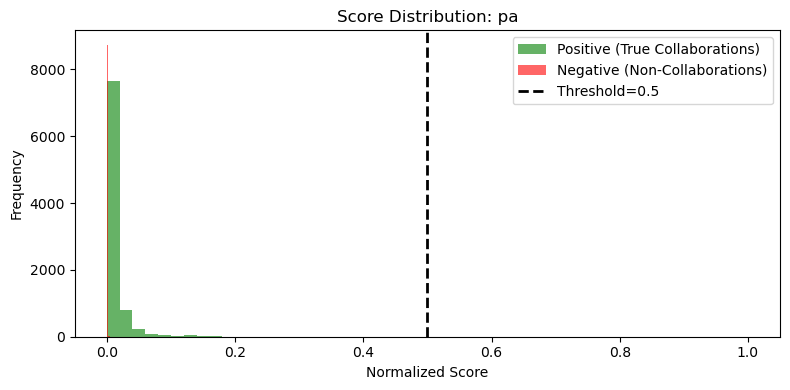

evaluating Era2 - structural features

--- Metric: cn ---
AUC: 0.92461334996308
Precision: 1.0
Recall: 0.0004533348444494815
Recall: 0.0004533348444494815
  Hits@1000: 0.0840 (84/1000 top predictions are true edges)
  Hits@1000: 0.0840 (84/1000 top predictions are true edges)


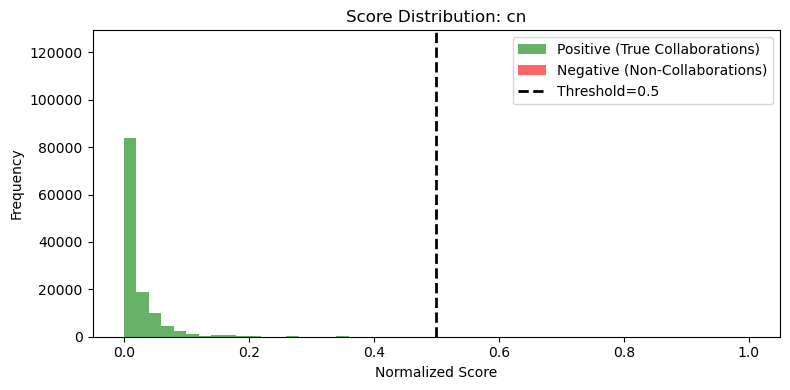


--- Metric: jaccard ---
AUC: 0.9240981558617917
Precision: 0.9991478483170004
AUC: 0.9240981558617917
Precision: 0.9991478483170004
Recall: 0.037966793222644075
Recall: 0.037966793222644075
  Hits@1000: 0.3870 (387/1000 top predictions are true edges)
  Hits@1000: 0.3870 (387/1000 top predictions are true edges)


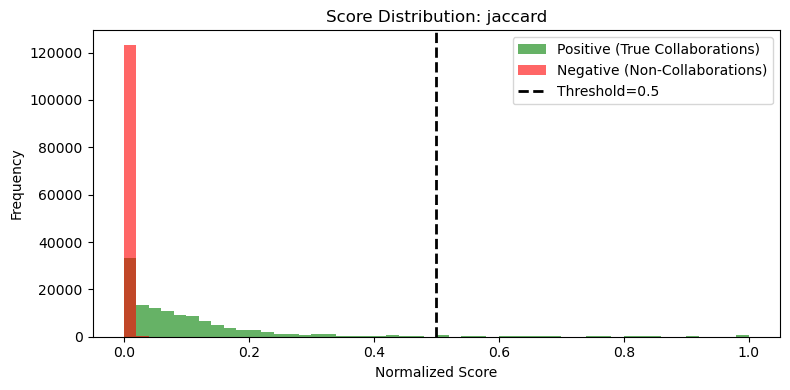


--- Metric: aa ---
AUC: 0.9244323030677808
Precision: 1.0
Recall: 3.238106031782011e-05
Precision: 1.0
Recall: 3.238106031782011e-05
  Hits@1000: 0.0780 (78/1000 top predictions are true edges)
  Hits@1000: 0.0780 (78/1000 top predictions are true edges)


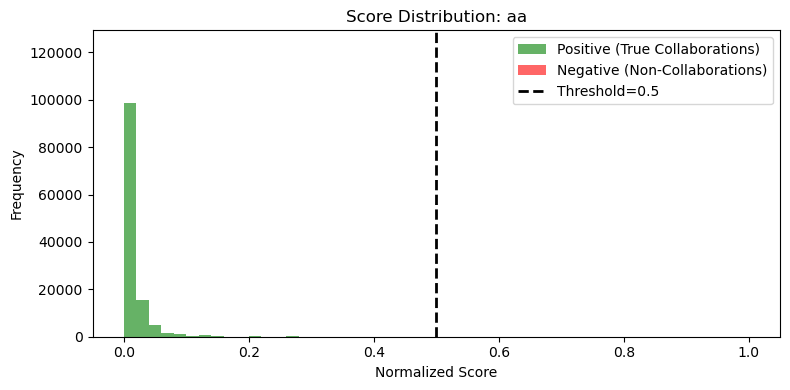


--- Metric: pa ---
AUC: 0.9570146935305205
Precision: 1.0
Recall: 0.0022181026317706774
Precision: 1.0
Recall: 0.0022181026317706774
  Hits@1000: 0.1000 (100/1000 top predictions are true edges)
  Hits@1000: 0.1000 (100/1000 top predictions are true edges)


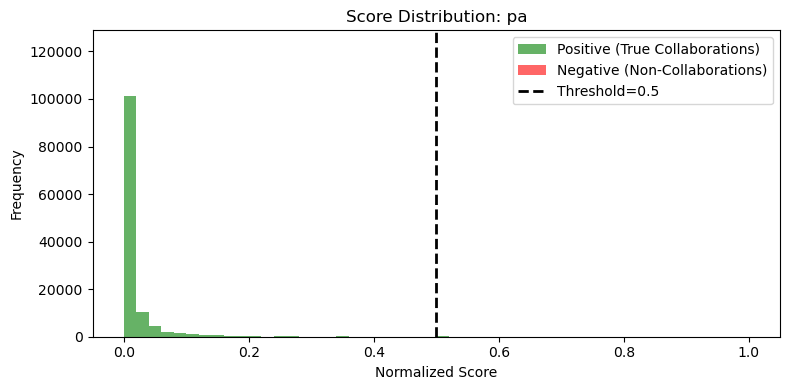

evaluating Era3 - structural features

--- Metric: cn ---
AUC: 0.9256787033201037
Precision: 1.0
Precision: 1.0
Recall: 9.062567969259769e-05
  Hits@1000: 0.0970 (97/1000 top predictions are true edges)
Recall: 9.062567969259769e-05
  Hits@1000: 0.0970 (97/1000 top predictions are true edges)


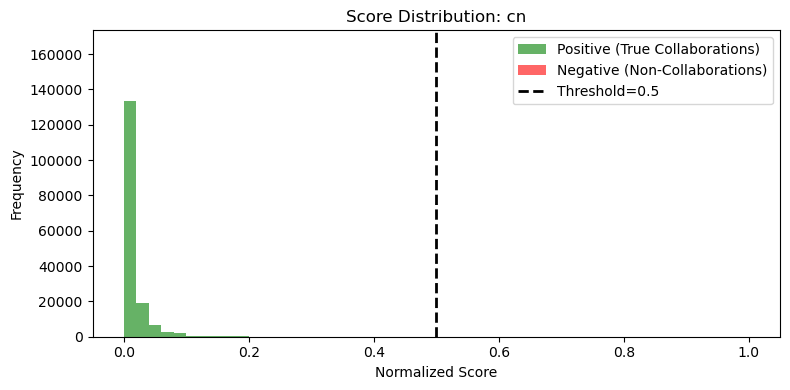


--- Metric: jaccard ---
AUC: 0.9252764737607064
Precision: 0.9996531390912244
Recall: 0.03482442784987554
AUC: 0.9252764737607064
Precision: 0.9996531390912244
Recall: 0.03482442784987554
  Hits@1000: 0.5380 (538/1000 top predictions are true edges)
  Hits@1000: 0.5380 (538/1000 top predictions are true edges)


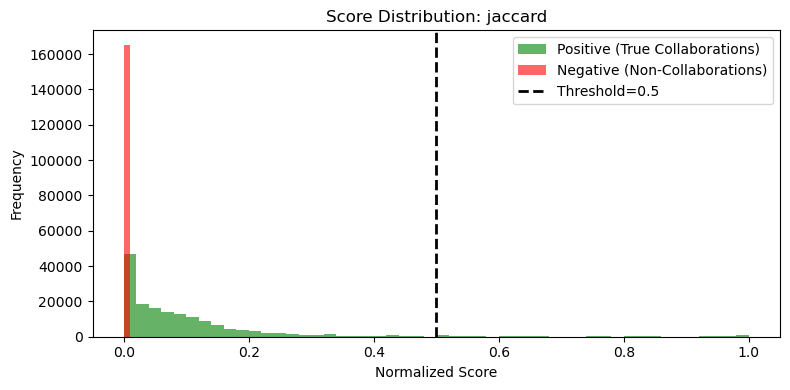


--- Metric: aa ---
AUC: 0.9252774794351231
Precision: 1.0
Recall: 7.854225573358467e-05
Precision: 1.0
Recall: 7.854225573358467e-05
  Hits@1000: 0.0930 (93/1000 top predictions are true edges)
  Hits@1000: 0.0930 (93/1000 top predictions are true edges)


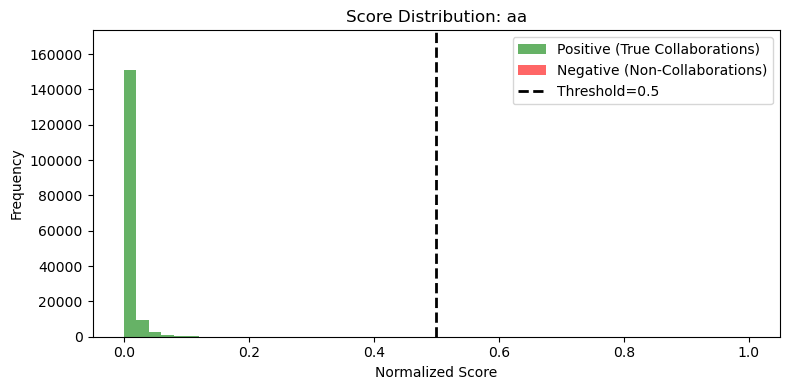


--- Metric: pa ---
AUC: 0.960883132426487
Precision: 1.0
Precision: 1.0
Recall: 0.0013473017714299524
  Hits@1000: 0.1120 (112/1000 top predictions are true edges)
Recall: 0.0013473017714299524
  Hits@1000: 0.1120 (112/1000 top predictions are true edges)


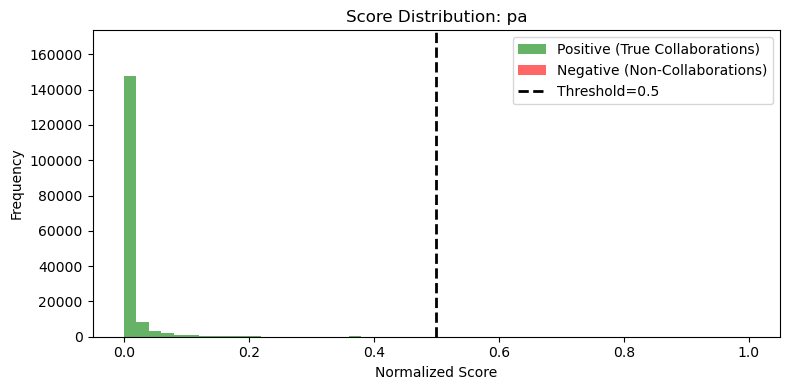

evaluating Era4 - structural features

--- Metric: cn ---
AUC: 0.8872725124925551
Precision: 1.0

--- Metric: cn ---
AUC: 0.8872725124925551
Precision: 1.0
Recall: 4.408726759711795e-05
  Hits@1000: 0.0750 (75/1000 top predictions are true edges)
Recall: 4.408726759711795e-05
  Hits@1000: 0.0750 (75/1000 top predictions are true edges)


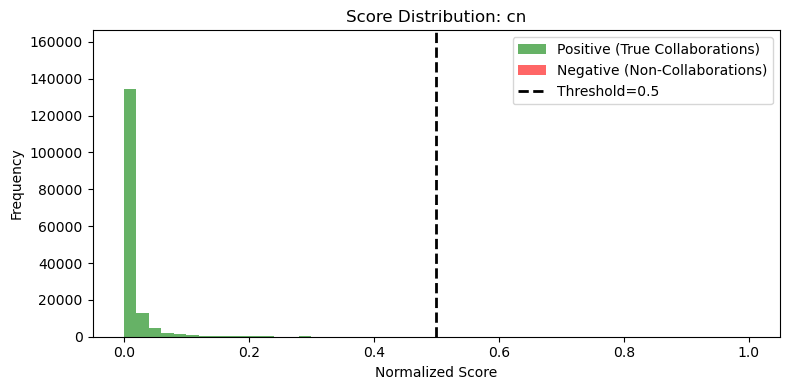


--- Metric: jaccard ---
AUC: 0.8868790050729164
Precision: 1.0
Recall: 0.03598150854033355
AUC: 0.8868790050729164
Precision: 1.0
Recall: 0.03598150854033355
  Hits@1000: 0.6200 (620/1000 top predictions are true edges)
  Hits@1000: 0.6200 (620/1000 top predictions are true edges)


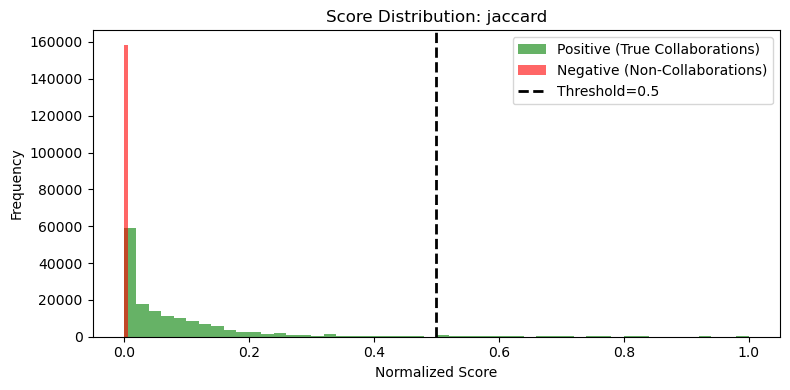


--- Metric: aa ---
AUC: 0.8868609422294311
Precision: 1.0
Recall: 4.408726759711795e-05
Precision: 1.0
Recall: 4.408726759711795e-05
  Hits@1000: 0.0750 (75/1000 top predictions are true edges)
  Hits@1000: 0.0750 (75/1000 top predictions are true edges)


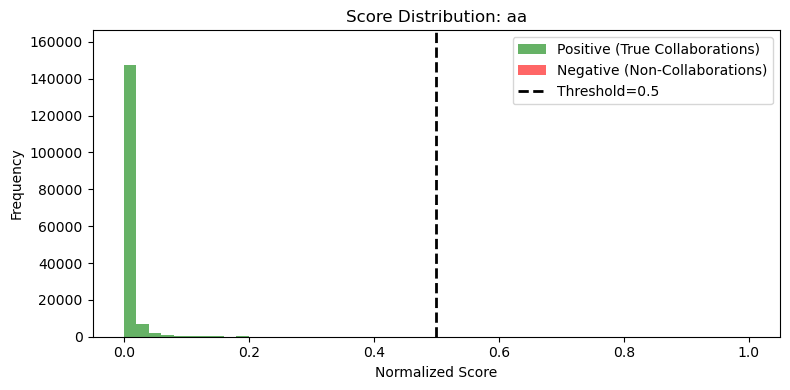


--- Metric: pa ---
AUC: 0.9362032831505653
Precision: 1.0
Recall: 0.0024122033556708824
Precision: 1.0
Recall: 0.0024122033556708824
  Hits@1000: 0.1060 (106/1000 top predictions are true edges)
  Hits@1000: 0.1060 (106/1000 top predictions are true edges)


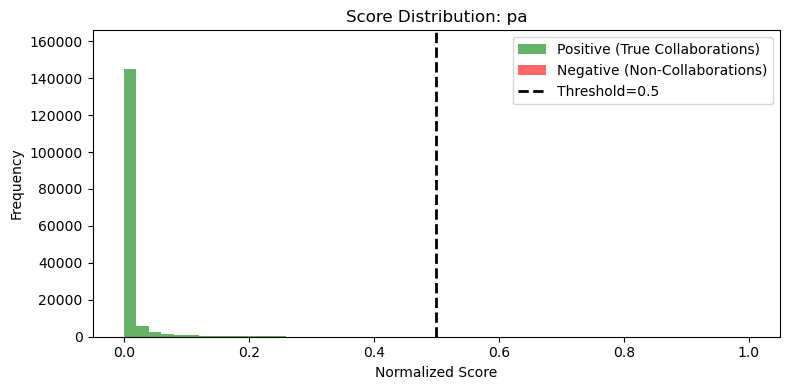

evaluating Era5 - structural features

--- Metric: cn ---
AUC: 0.7528297119884948
Precision: 1.0
Precision: 1.0
Recall: 5.1497548716681086e-05
Recall: 5.1497548716681086e-05
  Hits@1000: 0.2150 (215/1000 top predictions are true edges)
  Hits@1000: 0.2150 (215/1000 top predictions are true edges)


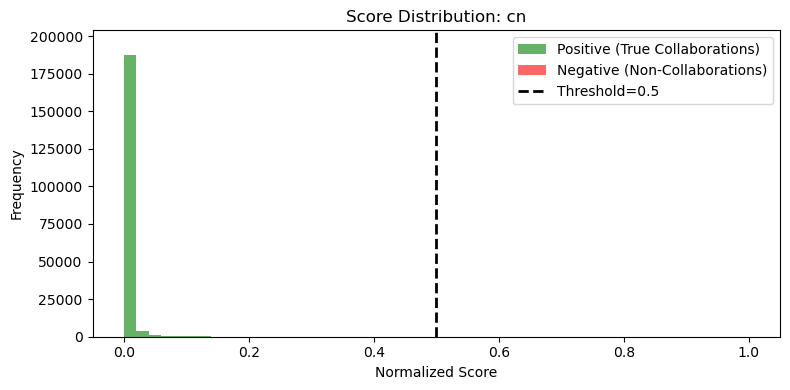


--- Metric: jaccard ---

AUC: 0.7527798867496366
Precision: 0.9995921696574225
AUC: 0.7527798867496366
Precision: 0.9995921696574225
Recall: 0.025244098380917068
Recall: 0.025244098380917068
  Hits@1000: 0.5740 (574/1000 top predictions are true edges)
  Hits@1000: 0.5740 (574/1000 top predictions are true edges)


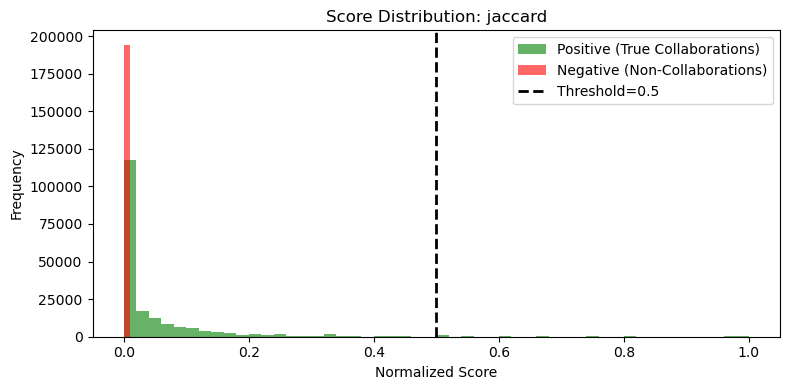


--- Metric: aa ---
AUC: 0.7525410254565216
Precision: 1.0
Precision: 1.0
Recall: 5.1497548716681086e-05
Recall: 5.1497548716681086e-05
  Hits@1000: 0.2150 (215/1000 top predictions are true edges)
  Hits@1000: 0.2150 (215/1000 top predictions are true edges)


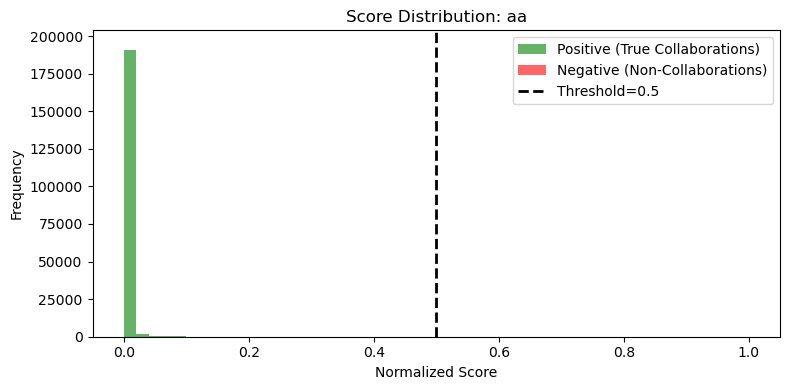


--- Metric: pa ---
AUC: 0.8873747783601555
Precision: 1.0
Precision: 1.0
Recall: 0.0008548593086969061
Recall: 0.0008548593086969061
  Hits@1000: 0.2880 (288/1000 top predictions are true edges)
  Hits@1000: 0.2880 (288/1000 top predictions are true edges)


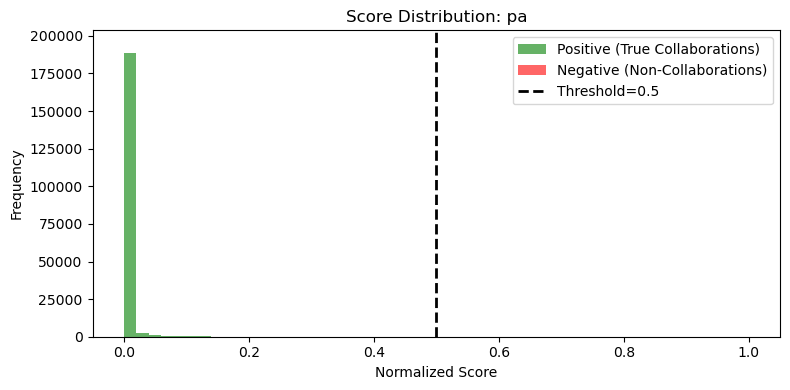


structural features:
 metric      auc  precision   recall  hits_at_k  era
     cn 0.862780   1.000000 0.000225      0.192 Era1
jaccard 0.862503   1.000000 0.082875      0.241 Era1
     aa 0.861944   1.000000 0.000225      0.197 Era1
     pa 0.926583   1.000000 0.000225      0.258 Era1
     cn 0.924613   1.000000 0.000453      0.084 Era2
jaccard 0.924098   0.999148 0.037967      0.387 Era2
     aa 0.924432   1.000000 0.000032      0.078 Era2
     pa 0.957015   1.000000 0.002218      0.100 Era2
     cn 0.925679   1.000000 0.000091      0.097 Era3
jaccard 0.925276   0.999653 0.034824      0.538 Era3
     aa 0.925277   1.000000 0.000079      0.093 Era3
     pa 0.960883   1.000000 0.001347      0.112 Era3
     cn 0.887273   1.000000 0.000044      0.075 Era4
jaccard 0.886879   1.000000 0.035982      0.620 Era4
     aa 0.886861   1.000000 0.000044      0.075 Era4
     pa 0.936203   1.000000 0.002412      0.106 Era4
     cn 0.752830   1.000000 0.000051      0.215 Era5
jaccard 0.752780   0.999

In [21]:
# evaluate structural features for all eras
structural_eval_results = []

for era in ['Era1', 'Era2', 'Era3', 'Era4', 'Era5']:
    print(f"evaluating {era} - structural features")
    
    df = all_results[era].copy()
    
    for metric in ['cn', 'jaccard', 'aa', 'pa']:
        print(f"\n--- Metric: {metric} ---")
        
        # evals with column normalized
        df = normalizeCol(df, metric)
        result = evaluate(df, metric, threshold=0.5)
        result['era'] = era
        structural_eval_results.append(result)

structural_eval_df = pd.DataFrame(structural_eval_results)
print(f"\nstructural features:")
print(structural_eval_df.to_string(index=False))

## Evaluating Communited Based Features

eval for Era1

--- Metric: same_community ---
AUC: 0.915665356541269
Precision: 0.969673899251364
Recall: 0.8581695676586187
  Hits@1000: 0.6310 (631/1000 top predictions are true edges)
Precision: 0.969673899251364
Recall: 0.8581695676586187
  Hits@1000: 0.6310 (631/1000 top predictions are true edges)


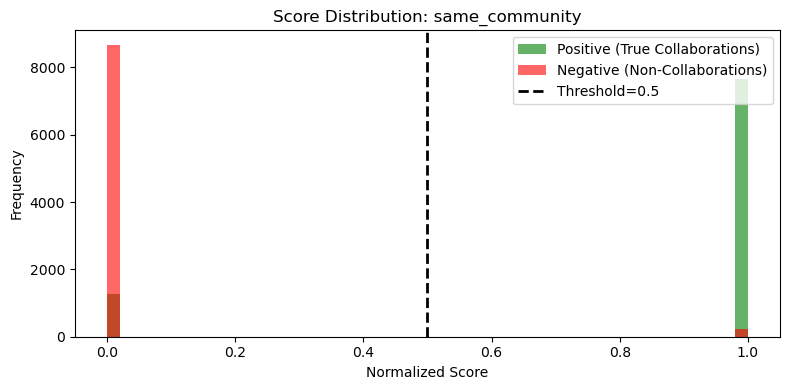


--- Metric: within_community_cn ---
AUC: 0.8428666367587748
Precision: 1.0
Recall: 0.0022459292532285235
  Hits@1000: 0.1960 (196/1000 top predictions are true edges)


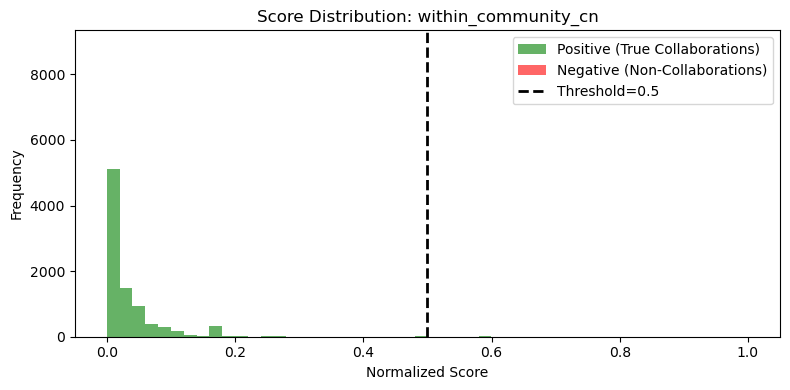

eval for Era2

--- Metric: same_community ---
AUC: 0.8845898533947494
Precision: 0.9681790409365946
Recall: 0.7953193177310591
Precision: 0.9681790409365946
Recall: 0.7953193177310591
  Hits@1000: 0.8830 (883/1000 top predictions are true edges)
  Hits@1000: 0.8830 (883/1000 top predictions are true edges)


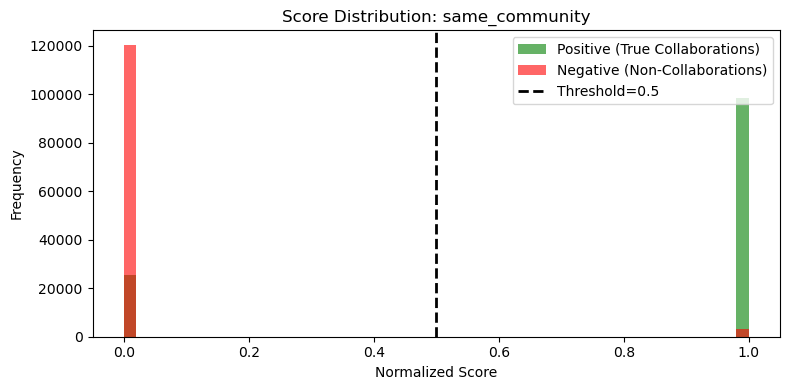


--- Metric: within_community_cn ---
AUC: 0.8573193898411683
Precision: 1.0
Recall: 0.00044523957937002645
Precision: 1.0
Recall: 0.00044523957937002645
  Hits@1000: 0.0900 (90/1000 top predictions are true edges)
  Hits@1000: 0.0900 (90/1000 top predictions are true edges)


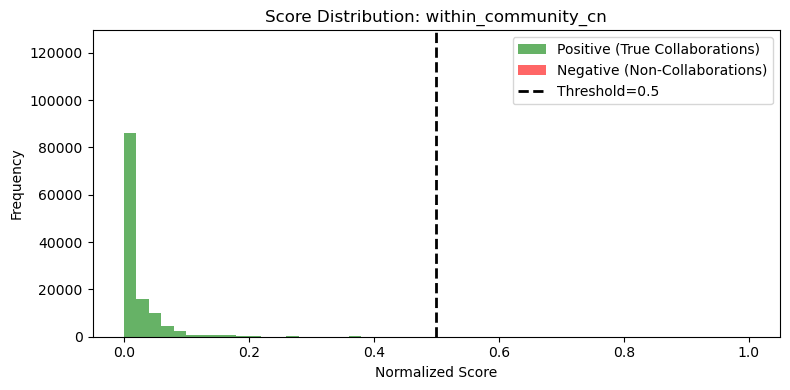

eval for Era3

--- Metric: same_community ---
AUC: 0.8592613402933856
Precision: 0.9797648919261274
Precision: 0.9797648919261274
Recall: 0.7336752942313735
  Hits@1000: 0.9170 (917/1000 top predictions are true edges)
Recall: 0.7336752942313735
  Hits@1000: 0.9170 (917/1000 top predictions are true edges)


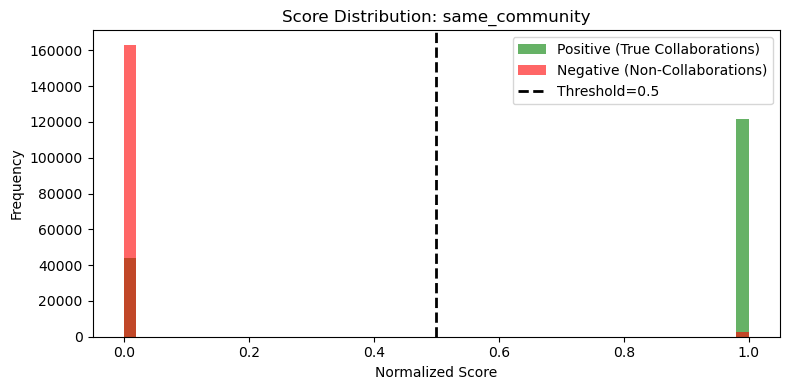


--- Metric: within_community_cn ---
AUC: 0.8241820555614915
Precision: 1.0
Recall: 0.00010875081563111724
AUC: 0.8241820555614915
Precision: 1.0
Recall: 0.00010875081563111724
  Hits@1000: 0.1050 (105/1000 top predictions are true edges)
  Hits@1000: 0.1050 (105/1000 top predictions are true edges)


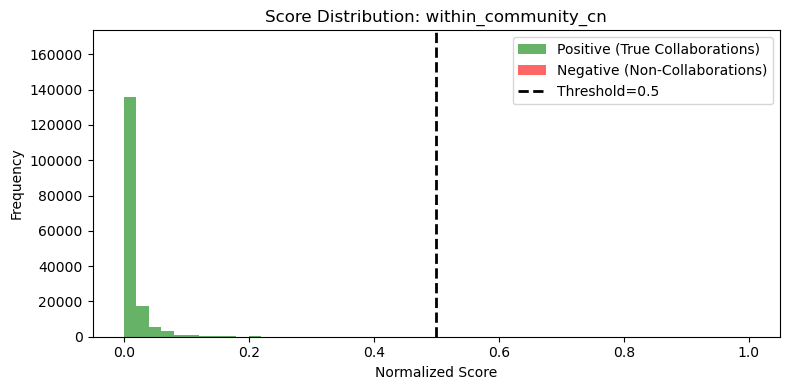

eval for Era4

--- Metric: same_community ---
AUC: 0.8378123897818309
Precision: 0.9767477001022177
Recall: 0.6921008212828135
  Hits@1000: 0.9260 (926/1000 top predictions are true edges)
Recall: 0.6921008212828135
  Hits@1000: 0.9260 (926/1000 top predictions are true edges)


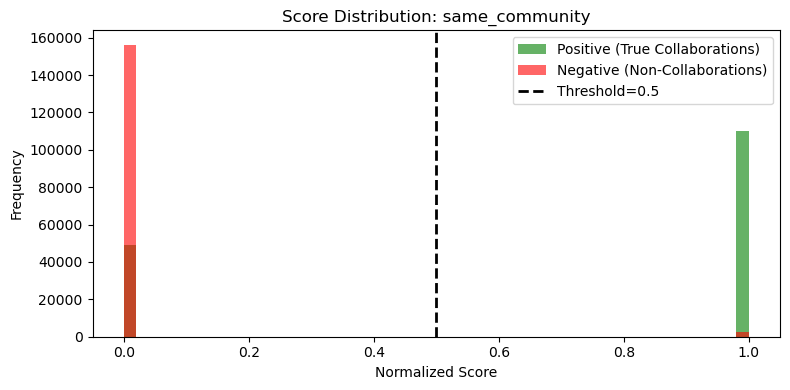


--- Metric: within_community_cn ---
AUC: 0.7860267032534427
Precision: 1.0
Recall: 0.0006046253841890462
  Hits@1000: 0.0850 (85/1000 top predictions are true edges)
Recall: 0.0006046253841890462
  Hits@1000: 0.0850 (85/1000 top predictions are true edges)


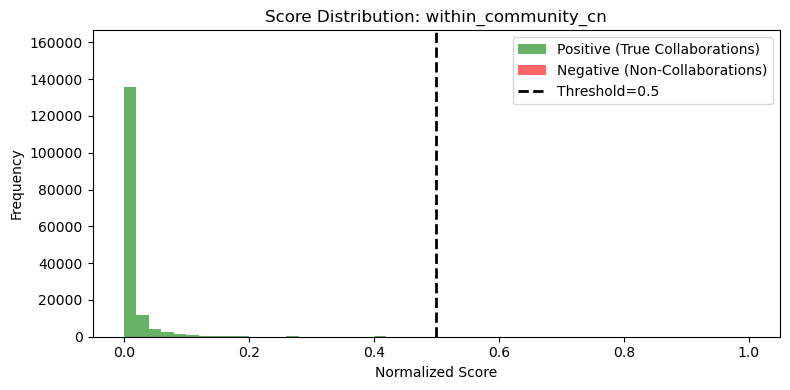

eval for Era5

--- Metric: same_community ---
AUC: 0.8607738021670168
Precision: 0.970042202585831

--- Metric: same_community ---
AUC: 0.8607738021670168
Precision: 0.970042202585831
Recall: 0.7445412598360318
  Hits@1000: 0.8020 (802/1000 top predictions are true edges)
Recall: 0.7445412598360318
  Hits@1000: 0.8020 (802/1000 top predictions are true edges)


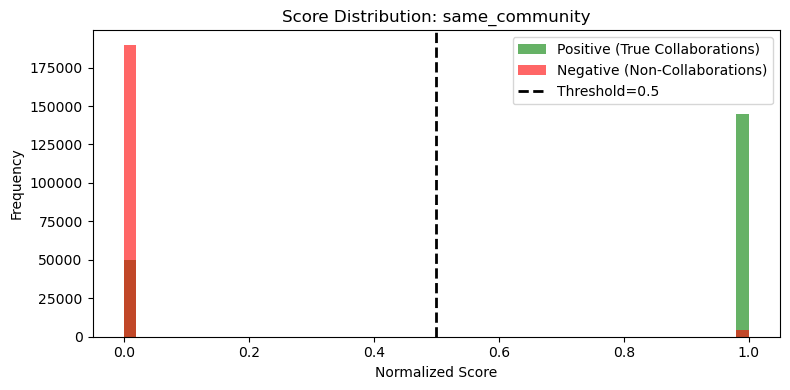


--- Metric: within_community_cn ---
AUC: 0.7266773768154193
Precision: 1.0
Recall: 5.1497548716681086e-05
  Hits@1000: 0.2230 (223/1000 top predictions are true edges)
Recall: 5.1497548716681086e-05
  Hits@1000: 0.2230 (223/1000 top predictions are true edges)


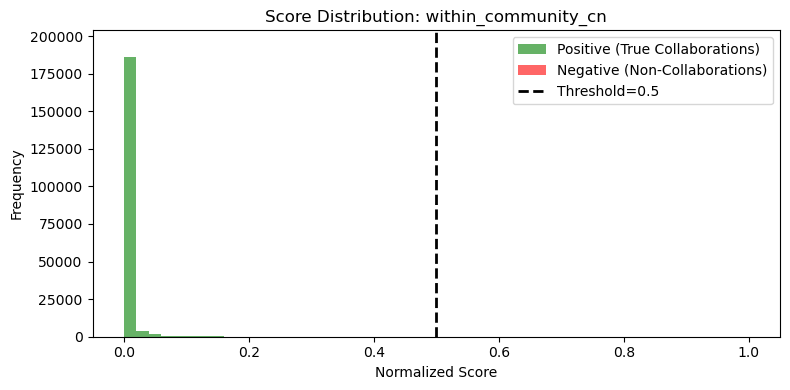

             metric      auc  precision   recall  hits_at_k  era
     same_community 0.915665   0.969674 0.858170      0.631 Era1
within_community_cn 0.842867   1.000000 0.002246      0.196 Era1
     same_community 0.884590   0.968179 0.795319      0.883 Era2
within_community_cn 0.857319   1.000000 0.000445      0.090 Era2
     same_community 0.859261   0.979765 0.733675      0.917 Era3
within_community_cn 0.824182   1.000000 0.000109      0.105 Era3
     same_community 0.837812   0.976748 0.692101      0.926 Era4
within_community_cn 0.786027   1.000000 0.000605      0.085 Era4
     same_community 0.860774   0.970042 0.744541      0.802 Era5
within_community_cn 0.726677   1.000000 0.000051      0.223 Era5


In [22]:
#same concept as above
community_eval_results = []

for era in ['Era1', 'Era2', 'Era3', 'Era4', 'Era5']:
    print(f"eval for {era}")
    df = community_results[era].copy()
    
    # eval for each metric
    for metric in ['same_community', 'within_community_cn']:
        print(f"\n--- Metric: {metric} ---")
        
        df = normalizeCol(df, metric)
        result = evaluate(df, metric, threshold=0.5)
        result['era'] = era
        community_eval_results.append(result)

community_eval_df = pd.DataFrame(community_eval_results)
print(community_eval_df.to_string(index=False))